In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from matplotlib import pyplot as plt

In [2]:
#parameters setting

#Define the path to your datafolder below
your_datapath = ''

#Define search space for number of trees in random forest and depth of trees
num_trees_min = 4
num_trees_max = 8

depth_min = 2
depth_max = 4

In [3]:
#Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries
def make_district_df_semiyearly(datapath, district_name):
    """
    Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder
    district_name : string
        Name of the district

    Returns
    -------
    df : pandas dataframe
    """

	#Read all relevant datasets
    prevalence_df = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    covid_df = pd.read_csv(datapath + 'covid.csv', parse_dates=['date'])
    ipc_df = pd.read_csv(datapath + 'ipc2.csv', parse_dates=['date'])
    risk_df = pd.read_csv(datapath + 'FSNAU_riskfactors.csv', parse_dates=['date'])
    production_df = pd.read_csv(datapath + 'production.csv', parse_dates=['date'])
    
    #Select data for specific district
    prevalence_df = prevalence_df[prevalence_df['district']==district_name]
    ipc_df = ipc_df[ipc_df['district']==district_name]
    risk_df = risk_df[risk_df['district']==district_name]
    production_df = production_df[production_df['district']==district_name]
    
    #GroupBy "key", 6M = 6 months, x.replace(day=1) = the first day of that month
    risk_df = risk_df.groupby(pd.Grouper(key='date', freq='6M')).mean() 
    risk_df = risk_df.reset_index()
    risk_df['date'] = risk_df['date'].apply(lambda x : x.replace(day=1))
    
    covid_df = covid_df.groupby(pd.Grouper(key='date', freq='6M')).sum()
    covid_df = covid_df.reset_index()
    covid_df['date'] = covid_df['date'].apply(lambda x : x.replace(day=1))
    
    production_df['cropdiv'] = production_df.count(axis=1)
    
    #Sort dataframes on date
    prevalence_df.sort_values('date', inplace=True)
    covid_df.sort_values('date', inplace=True)
    ipc_df.sort_values('date', inplace=True)
    risk_df.sort_values('date', inplace=True)
    production_df.sort_values('date', inplace=True)

    #Merge dataframes, only joining on current or previous dates as to prevent data leakage
    df = pd.merge_asof(left=prevalence_df, right=ipc_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=production_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=risk_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=covid_df, direction='backward', on='date')
    
    #Calculate prevalence 6lag
    df['prevalence_6lag'] = df['GAM Prevalence'].shift(1)
    df['next_prevalence'] = df['GAM Prevalence'].shift(-1)
    
    #Select needed columns
    df = df[['date', 'district', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score', 'phase3plus_perc', 'cropdiv', 'total population']]
    df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc', 'cropdiv', 'population']
    
    #Add month column
    df['month'] = df['date'].dt.month
    
    #Add target variable: increase for next month prevalence (boolean)
    increase = [False if x[1]<x[0] else True for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase.append(False)
    df['increase'] = increase
    df.iloc[-1, df.columns.get_loc('increase')] = np.nan #No info on next month
    
    #Add target variable: increase for next month prevalence (boolean)
    increase_numeric = [x[1] - x[0] for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase_numeric.append(0)
    df['increase_numeric'] = increase_numeric
    df.iloc[-1, df.columns.get_loc('increase_numeric')] = np.nan #No info on next month
    
    df.loc[(df.date < pd.to_datetime('2020-03-01')), 'covid'] = 0
    
    return(df)

In [4]:
#Function that combines the semiyearly dataset (from the function make_district_df_semiyearly) of all districts
def make_combined_df_semiyearly(datapath):
    """
    Function that creates a pandas dataframe for all districts with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder

    Returns
    -------
    df : pandas dataframe
    """

    prevdf = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    districts = prevdf['district'].unique()
    
    df_list = []
    for district in districts:
        district_df = make_district_df_semiyearly(datapath, district)
        district_df['district'] = district
        df_list.append(district_df)
        
    df = pd.concat(df_list, ignore_index=True)
    df['district_encoded'] = df['district'].astype('category').cat.codes

    return df


In [5]:
#Function that returns every possible subset (except the empty set) of the input list l
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list


In [6]:
'''------------SECTION DATAFRAME CREATION--------------'''
#Create the dataframe for all districts
df = make_combined_df_semiyearly(your_datapath)


In [7]:

#Drop every row with missing values
df.dropna(inplace=True)

#Sort dataframe on date and reset the index
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)

#Drop disctricts with less than 7 observations: 'Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'
df.drop(df[df['district'].isin(['Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'])].index, inplace=True)


In [14]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
#WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

#Create empty list to store model scores
parameter_scores = []

#Define target and explanatory variables
X = df.drop(columns = ['increase', 'increase_numeric', 'date', 'district', 'prevalence', 'next_prevalence']) #Note that these columns are dropped, the remaining columns are used as explanatory variables
y = df['next_prevalence'].values

#for num_trees in range(num_trees_min, num_trees_max):
    
    #for depth in range(depth_min, depth_max):
        
        #Investigate every subset of explanatory variables
        #for features in subsets(X.columns):

num_trees = 4
depth = 4
features = X.columns
        
#First CV split. The 99 refers to the first 3 observations for the 33 districts in the data.
Xtrain = X[:99][features].copy().values
ytrain = y[:99]
Xtest = X[99:132][features].copy().values
ytest = y[99:132]

#Create a RandomForestRegressor with the selected hyperparameters and random state 0.
clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

#Fit to the training data
clf.fit(Xtrain, ytrain)

#Make a prediction on the test data
predictions = clf.predict(Xtest)

#Calculate mean absolute error
MAE1 = mean_absolute_error(ytest, predictions)


#Second CV split. The 132 refers to the first 4 observations for the 33 districts in the data.
Xtrain = X[:132][features].copy().values
ytrain = y[:132]
Xtest = X[132:165][features].copy().values
ytest = y[132:165]

#Create a RandomForestRegressor with the selected hyperparameters and random state 0.
clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

#Fit to the training data
clf.fit(Xtrain, ytrain)

#Make a prediction on the test data
predictions = clf.predict(Xtest)

#Calculate mean absolute error
MAE2 = mean_absolute_error(ytest, predictions)

#Calculate the mean MAE over the two folds
mean_MAE = (MAE1 + MAE2)/2

#Store the mean MAE together with the used hyperparameters in list 
parameter_scores.append((mean_MAE, num_trees, depth, features))

#Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

In [15]:
'''------------SECTION FINAL EVALUATION--------------'''
X = df[best_model_columns].values
y = df['next_prevalence'].values

#If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
	X = X.reshape(-1, 1)

#Peform evaluation on full data
Xtrain = X[:165]
ytrain = y[:165]
Xtest = X[165:]
ytest = y[165:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

#Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

#Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase           = [0 if x<y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']]
predicted_increase = [0 if x<y else 1 for x in predictions                      for y in df.iloc[165:]['prevalence']]

#Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

#Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(best_model_columns))

#Print model scores
print(MAE, acc)

no. of trees: 4
max_depth: 4
columns: ['prevalence_6lag', 'covid', 'ndvi', 'ipc', 'cropdiv', 'population', 'month', 'district_encoded']
0.05988653100556797 0.8335629017447199


Text(0.5, 0, 'Random Forest Feature Importance')

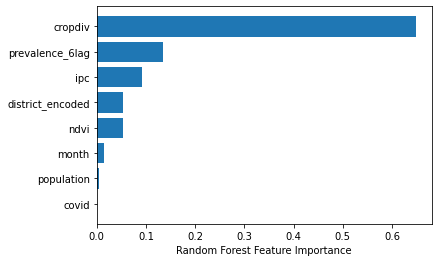

In [16]:
sorted_idx = clf.feature_importances_.argsort()
best_model_columns = np.array(best_model_columns)
plt.barh(best_model_columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")